### To run this Notebook, first load the .pkl files. You can find it here: https://drive.google.com/drive/folders/1KwJxeukPT2_lZQfNUbG7-VCjjddfRA0I?usp=sharing

### - Using Poisson for weekdays, weekends, elective and urgent admissions
### - Currently using KDEs to simulate length of stay
### - The plot shows total number of ICU patients and the daily elective and urgent admissions.

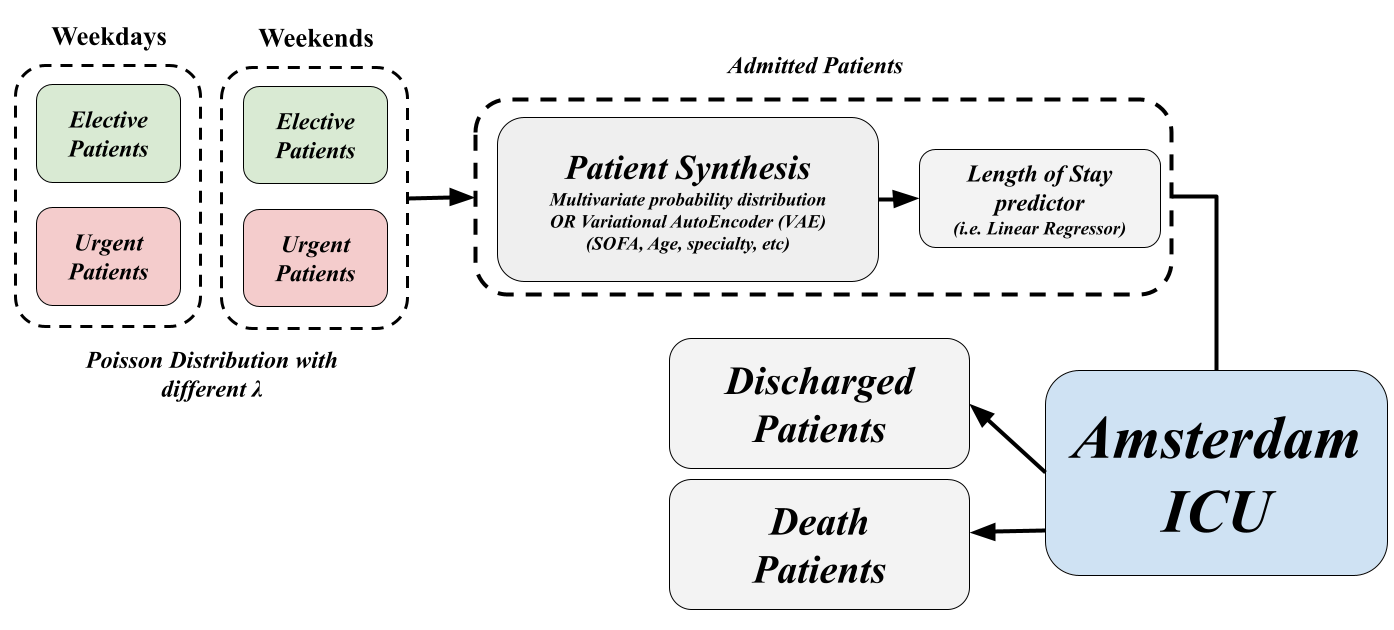

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import rc
import seaborn as sns
from sklearn.neighbors import KernelDensity
import pickle
import random

In [2]:

# How many beds does the Amsterdam UMC ICU have?
# https://www.vumc.com/departments/adult-intensive-care.htm

numOfBeds = 35 # for visualization only
numOfDays = 460 # number of days I want to run the simulation
lambdaUrgentPatients = 1.1 # lamdbda for the urgent patients per day
lambdaElectivePatients = 3 # lambda for the elective patients per day
simulateStopCardiacSurgery = False
dayStopAdmittingCardiacSugery = 50
dayContinueAdmittingCardiacSurgery = 200

# Parameters of the simulated dataset
maxOfICUDaysUrgent = 15 # mean of a normal distribution - this should come from the dataset
maxOfICUDaysElective = 2 # mean of a normal distribution - this should come from the dataset

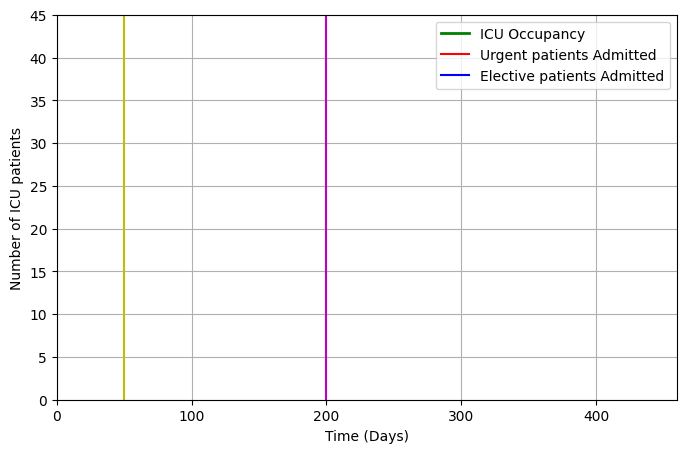

In [3]:
# create a figure and axes
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot()

# set up the subplots as needed
ax1.set_xlim(( 0, numOfDays))
ax1.set_ylim((0, numOfBeds+10))
ax1.set_xlabel('Time (Days)')
ax1.set_ylabel('Number of ICU patients')
ax1.grid()

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('')
line1, = ax1.plot([], label='ICU Occupancy', color='g', lw=2)
line2, = ax1.plot([], label='Urgent patients Admitted', color='r', lw=1.5)
line3, = ax1.plot([], label='Elective patients Admitted', color='b', lw=1.5)
ax1.axvline(x=dayStopAdmittingCardiacSugery, ymin=0, ymax=numOfBeds, color='y')
ax1.axvline(x=dayContinueAdmittingCardiacSurgery, ymin=0, ymax=numOfBeds, color='m')

ax1.legend(handles =[line1, line2, line3], loc ='upper right')

In [4]:
# Initialization function
def init():

  global time, total_patients, urgent_patients, elective_patients, allLoS, dischargedPatients, totalPatientsInICU, excessPatients, elective_kernels_LoS, urgent_kernels_LoS

  time = np.array([0])
  total_patients = np.array([0])
  urgent_patients = np.array([0])
  elective_patients = np.array([0])
  line1.set_data(time, total_patients)
  line2.set_data(time, urgent_patients)
  line3.set_data(time, elective_patients)
  txt_title.set_text('Frame = {0:4d}'.format(0))

  allLoS = np.array([0])
  dischargedPatients = 0
  totalPatientsInICU = 0
  excessPatients = 0

  with open('elective_kernels.pkl', 'rb') as f:
    elective_kernels_LoS = pickle.load(f)

  with open('urgent_kernels.pkl', 'rb') as f:
    urgent_kernels_LoS = pickle.load(f)

  return line1

In [5]:
urgentTypes = ['Unknown',
               'Non-operative neurologic',
               'Non-operative respiratory',
               'Non-operative cardiovascular',
               'Non-operative genitourinary',
               'Non-operative metabolic',
               'Non-operative Gastro-intestinal',
               'Post-operative gastro-intestinal',
               'Post-operative trauma',
               'Post-operative respiratory',
               'Post-operative neurologic',
               'Post-operative cardiovascular',
               'Post-operative genitourinary',
               'Post-operative musculoskeletal /skin',
               'Non-operative trauma',
               'Non-operative musculo-skeletal',
               'Post-operative transplant',
               'Non-operative hematological',
               'Post-operative hematology']

electiveTypes = ['Unknown',
                 'Non-operative metabolic',
                 'Non-operative cardiovascular',
                 'Non-operative respiratory',
                 'Non-operative Gastro-intestinal',
                 'Post-operative cardiovascular',
                 'Non-operative neurologic',
                 'Non-operative genitourinary',
                 'Post-operative gastro-intestinal',
                 'Non-operative hematological',
                 'Post-operative respiratory',
                 'Post-operative genitourinary',
                 'Post-operative metabolic',
                 'Post-operative trauma',
                 'Non-operative musculo-skeletal',
                 'Post-operative neurologic',
                 'Post-operative musculoskeletal /skin',
                 'Post-operative transplant',
                 'Non-operative transplant',
                 'Post-operative hematology',
                 'Non-operative trauma']

In [6]:
# Using the CSV file
def modelLoS(patientsAdmitted, urgent, stopCardiac=False):
  global elective_kernels_LoS, urgent_kernels_LoS
  # Here I randomly select patients from the CSV file for urgent and non urgent
  if urgent:
    sampledUrgent = random.choices(urgentTypes, k=int(patientsAdmitted))
    urgentOutLoS = []
    for i in sampledUrgent:
      urgentOutLoS.append(np.ceil(urgent_kernels_LoS[i].sample(1)/24)) # Convert legth of stay in days
    return np.array(urgentOutLoS)
  else:
    if stopCardiac:
      sampledElective = random.choices(electiveTypes, k=int(patientsAdmitted))
      sampledElective = [t for t in sampledElective if t != 'Post-operative cardiovascular']
      electiveOutLoS = []
      for i in sampledElective:
        electiveOutLoS.append(np.ceil(elective_kernels_LoS[i].sample(1)/24)) # Convert legth of stay in days
      return np.array(electiveOutLoS)
    else:
      sampledElective = random.choices(electiveTypes, k=int(patientsAdmitted))
      electiveOutLoS = []
      for i in sampledElective:
        electiveOutLoS.append(np.ceil(elective_kernels_LoS[i].sample(1)/24)) # Convert legth of stay in days
      return np.array(electiveOutLoS)

In [7]:
def patientList(totalPatients, urgentPatients, electivePatients, n):

  global allLoS, dischargedPatients, totalPatientsInICU, excessPatients, numOfBeds

  # Weekends - We assume the day zero is Sunday - Weekends days: 6, 7, 13, 14, 20, 21, 27, 28, 34, 35 ...
  if ((n+1)%7==0) or (n%7==0):
    # number of admitted elective patients per day
    electivePatientsAdmitted = 0
    # number of admitted urgent patients per day
    urgentPatientsAdmitted = np.random.poisson(lambdaUrgentPatients, 1)
    totalPatientsInICU += urgentPatientsAdmitted[0]
    # predict the length for each of the admited patient
    allLoS = np.append(allLoS, n + modelLoS(urgentPatientsAdmitted, True))

  # Weekdays
  else:
    # number of admitted elective patients per day
    electivePatientsAdmitted = np.random.poisson(lambdaElectivePatients, 1)

    if simulateStopCardiacSurgery:

      # predict the length for each of the admited patient
      if n > dayStopAdmittingCardiacSugery and n < dayContinueAdmittingCardiacSurgery:
        LoSPredicted = modelLoS(electivePatientsAdmitted, False, True)
        allLoS = np.append(allLoS, n + LoSPredicted)
        totalPatientsInICU += len(LoSPredicted)
      else:
        LoSPredicted = modelLoS(electivePatientsAdmitted, False)
        allLoS = np.append(allLoS, n + LoSPredicted)
        totalPatientsInICU += len(LoSPredicted)

    else:

      LoSPredicted = modelLoS(electivePatientsAdmitted, False)
      allLoS = np.append(allLoS, n + LoSPredicted)
      totalPatientsInICU += len(LoSPredicted)

    # number of admitted urgent patients per day
    urgentPatientsAdmitted = np.random.poisson(lambdaUrgentPatients, 1)
    totalPatientsInICU += urgentPatientsAdmitted[0]
    # predict the length for each of the admited patient
    allLoS = np.append(allLoS, n + modelLoS(urgentPatientsAdmitted, True))

  if n == 1: # remove the initialization number
    allLoS = allLoS[1:]

  # Discharged the patients for this day (n)
  if n in allLoS:
    dischargedPatients = np.count_nonzero(allLoS == n)
    allLoS = allLoS[allLoS != n]
  else:
    dischargedPatients = 0

  # Reduce the patient count
  totalPatientsInICU -= dischargedPatients

  if totalPatientsInICU > numOfBeds:
    print(f"Alert in day {n}! Don't admit elective patients")
    print(f"Number of elective patients admitted for day {n}: {electivePatientsAdmitted[0]}")

  # print(f"Number of total patients: {totalPatientsInICU}")
  # print(f"Number of patients discharged: {dischargedPatients}")

  urgentAdmissions = np.append(urgentPatients, urgentPatientsAdmitted)
  electiveAdmissions = np.append(electivePatients, electivePatientsAdmitted)
  totalICUPatients = np.append(totalPatients, totalPatientsInICU)

  return totalICUPatients, urgentAdmissions, electiveAdmissions

In [8]:
# simulation function. This is called sequentially
def ICUActivity(n):
    global time, total_patients, urgent_patients, elective_patients
    time = np.arange(0, n+1)
    if n > 0:
      total_patients, urgent_patients, elective_patients = patientList(total_patients, urgent_patients, elective_patients, n) # number of patients per day
    line1.set_data(time, total_patients)
    line2.set_data(time, urgent_patients)
    line3.set_data(time, elective_patients)
    txt_title.set_text('Frame = {0:4d}'.format(n))
    return line1

In [9]:
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, ICUActivity, init_func=init, frames=numOfDays+1, interval=20, blit=False)

In [10]:
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [11]:
anim

Alert in day 173! Don't admit elective patients
Number of elective patients admitted for day 173: 3
Alert in day 320! Don't admit elective patients
Number of elective patients admitted for day 320: 7
